## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

## Plotting function

In [2]:
def plot_3d(x, y, y_pred=None):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

## Defining Input

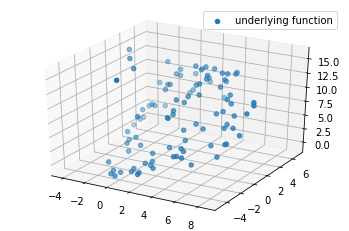

In [3]:
bias_true = torch.FloatTensor([1,-1])
x = rand_tensor = torch.rand((100, 3))
weights_1 = torch.FloatTensor([[1, 1,0],[1,0,1]]).T
weights_2 = torch.FloatTensor([[0,0,1],[0,1,0]]).T

y_true = torch.matmul(torch.square(x) , weights_1) +  torch.matmul(x , weights_2) + bias_true
X_embedded = TSNE(n_components=2).fit_transform(x)
y_embedded = TSNE(n_components=1).fit_transform(y_true)

plot_3d(X_embedded, y_embedded)

## Loss function and Linear layer


In [4]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient


class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = torch.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = torch.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = torch.square(x)@ self.weights + x @ self.weights + self.bias
    return output

  # dy/dx = 2*x*weights_true + weights_true
  # dy/dw = x2 + x
  # dy/db = 1
  
  def backward(self, gradient):
    self.weights_gradient = (torch.square(self.x) + self.x).T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T

    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

## Relu layer

In [5]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = torch.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

## Defining model

In [6]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, 6)
    self.relu = Relu()
    self.linear2 = Linear(6, 4)
    self.relu2 = Relu()
    self.linear3 = Linear(4, 2)

  
  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3
  
  def backward(self, output_gradient):

    linear3_gradient = self.linear3.backward(output_gradient)
    relu_gradient = self.relu2.backward(linear3_gradient)

    linear2_gradient = self.linear2.backward(relu_gradient)
    relu2_gradient = self.relu.backward(linear2_gradient)

    linear1_gradient = self.linear1.backward(relu2_gradient)
    return linear3_gradient

  def update(self, lr):
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(3, 1)
y_pred = model(x)

print("***********")
print(y_pred.shape)
print("***********")

loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()

print("***********")
print(loss_value)
print("***********")

model.backward(loss_gradient)

***********
torch.Size([100, 2])
***********
***********
tensor(262.8411)
***********


tensor([[-2.7580e-01, -1.1240e+00,  1.9160e-01,  9.4048e-01],
        [-1.6059e-01, -6.1830e-01,  1.2154e-01,  5.1363e-01],
        [ 1.0828e-02,  1.2319e-01,  1.4281e-02, -1.1118e-01],
        [-5.1180e-01, -2.1535e+00,  3.3693e-01,  1.8087e+00],
        [-8.4796e-02, -2.8522e-01,  7.5559e-02,  2.3246e-01],
        [-3.7204e-03,  4.3029e-02,  1.8632e-02, -4.1969e-02],
        [-2.1910e-02, -1.7838e-02,  3.4928e-02,  7.5988e-03],
        [-1.1941e-02,  2.4806e-02,  2.8557e-02, -2.8288e-02],
        [-7.7873e-02, -2.5256e-01,  7.1975e-02,  2.0468e-01],
        [-1.6459e-02,  2.4194e-02,  3.6604e-02, -2.9601e-02],
        [-1.2548e-01, -4.5985e-01,  1.0139e-01,  3.7947e-01],
        [-4.8904e-02, -1.1551e-01,  5.7086e-02,  8.8052e-02],
        [-9.6799e-03,  2.3725e-02,  2.4147e-02, -2.6329e-02],
        [-4.4783e-02, -1.0250e-01,  5.3178e-02,  7.7560e-02],
        [-3.2833e-02, -6.0063e-02,  4.3148e-02,  4.2693e-02],
        [-1.7384e-02,  1.7920e-03,  3.2109e-02, -8.9471e-03],
        

## Training function

************************
Epoch 0, loss 262.84112548828125
************************
************************
Epoch 1, loss 9.649450302124023
************************
************************
Epoch 2, loss 3.2390105724334717
************************
************************
Epoch 3, loss 3.007181406021118
************************
************************
Epoch 4, loss 2.794004440307617
************************
************************
Epoch 5, loss 2.597914457321167
************************
************************
Epoch 6, loss 2.4174933433532715
************************
************************
Epoch 7, loss 2.251466751098633
************************
************************
Epoch 8, loss 2.098668098449707
************************
************************
Epoch 9, loss 1.9580280780792236
************************
************************
Epoch 10, loss 1.8285696506500244
************************
************************
Epoch 11, loss 1.7094072103500366
************************
********

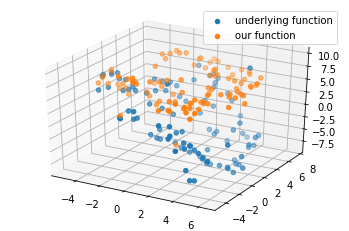

In [7]:
num_epochs=70
lr=0.02

for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y_true)
    print("************************")
    print(f'Epoch {epoch}, loss {loss_value}')
    print("************************")

    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)
    
y_pred= model(x).detach()
y_pred_embedded = TSNE(n_components=1).fit_transform(y_pred)
X_embedded = TSNE(n_components=2).fit_transform(x.detach())
y_embedded = TSNE(n_components=1).fit_transform(y_true)
plot_3d(X_embedded, y_embedded,y_pred_embedded)